In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import random
%matplotlib inline

In [63]:
args = {'lr':0.01,
        'train epochs':1500,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'correlation':0,
        'input features': 40,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler()
        }

now = datetime.now()

# Data Prep

In [64]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [65]:
df = pd.read_excel('data_3nm.xlsx')

In [66]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [67]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [68]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [69]:
# add noise
X_noisy = add_noise(X, args['noise'])

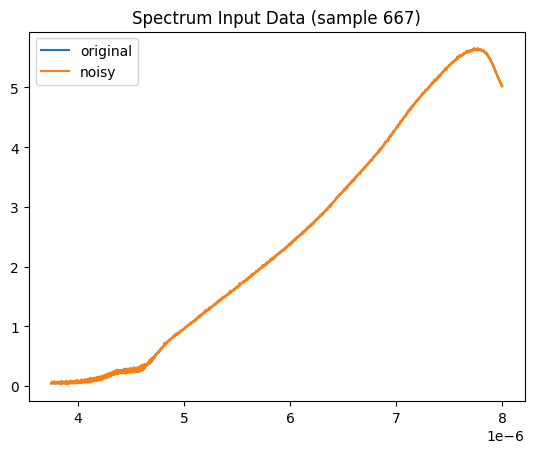

In [70]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [71]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [73]:
'''for layer in layers:
    inputs = X_train
    targets = y_train[layer['col']]

    rfe = RFE(estimator=LinearRegression(), n_features_to_select=args['input features'])

    rfe.fit(inputs, targets)

    selected_features = X.columns[rfe.support_]

    layer['features'] = selected_features

    print(f'Features for {layer["col"].capitalize()} ({len(selected_features)}):\n {selected_features}\n')


# select features that correlate more than given amount
for layer in layers:
    temp = X.copy()
    temp['layer'] = y[layer['col']]
    
    #features = temp.corr().abs()['layer'].sort_values(ascending=False).head(args['input features']+1).index[1:]
    
    corr_df = pd.DataFrame(temp.corr()['layer'].sort_values(ascending=False))
   
    features = []
    for index, row in corr_df.abs().iterrows():
        if index == 'layer':
            continue
        
        if row['layer'] > args['correlation']:
            features.append(index)
    
    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()} ({len(features)}):\n {features}\n')'''


'for layer in layers:\n    inputs = X_train\n    targets = y_train[layer[\'col\']]\n\n    rfe = RFE(estimator=LinearRegression(), n_features_to_select=args[\'input features\'])\n\n    rfe.fit(inputs, targets)\n\n    selected_features = X.columns[rfe.support_]\n\n    layer[\'features\'] = selected_features\n\n    print(f\'Features for {layer["col"].capitalize()} ({len(selected_features)}):\n {selected_features}\n\')\n\n\n# select features that correlate more than given amount\nfor layer in layers:\n    temp = X.copy()\n    temp[\'layer\'] = y[layer[\'col\']]\n    \n    #features = temp.corr().abs()[\'layer\'].sort_values(ascending=False).head(args[\'input features\']+1).index[1:]\n    \n    corr_df = pd.DataFrame(temp.corr()[\'layer\'].sort_values(ascending=False))\n   \n    features = []\n    for index, row in corr_df.abs().iterrows():\n        if index == \'layer\':\n            continue\n        \n        if row[\'layer\'] > args[\'correlation\']:\n            features.append(index)\

In [74]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train.values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test.values, dtype=torch.float32)

#[layer['features']]

In [75]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedForward, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 15)
        self.lin_fin = nn.Linear(15, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = self.lin_fin(x)
        return x

In [76]:
criterion = args['train criterion']

In [77]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    # instantiate model
    model = FeedForward(input.size()[1], target.size()[1])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])

    for epoch in range(args['train epochs']):
        # forward pass
        outputs = model(input)

        # get loss
        loss = criterion(outputs, target)

        # update and backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    # store model and losses
    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1


epoch: 150, loss = 4.158130168914795
epoch: 300, loss = 3.064169406890869
epoch: 450, loss = 2.759246349334717
epoch: 600, loss = 2.6474554538726807
epoch: 750, loss = 2.6161766052246094
epoch: 900, loss = 2.6122665405273438
epoch: 1050, loss = 2.6113874912261963
epoch: 1200, loss = 2.611132860183716
epoch: 1350, loss = 2.6109275817871094
epoch: 1500, loss = 2.610814094543457
best loss: 2.6107707023620605 in epoch 1499

layer 2
epoch: 150, loss = 7.7505998611450195
epoch: 300, loss = 6.55535888671875
epoch: 450, loss = 6.061924934387207
epoch: 600, loss = 5.750011920928955
epoch: 750, loss = 5.635514736175537
epoch: 900, loss = 5.58766508102417
epoch: 1050, loss = 5.57571268081665
epoch: 1200, loss = 5.574462413787842
epoch: 1350, loss = 5.573623180389404
epoch: 1500, loss = 5.573309421539307
best loss: 5.573309421539307 in epoch 1500

layer 3
epoch: 150, loss = 4.525221824645996
epoch: 300, loss = 3.7114739418029785
epoch: 450, loss = 3.3041110038757324
epoch: 600, loss = 3.1169700622

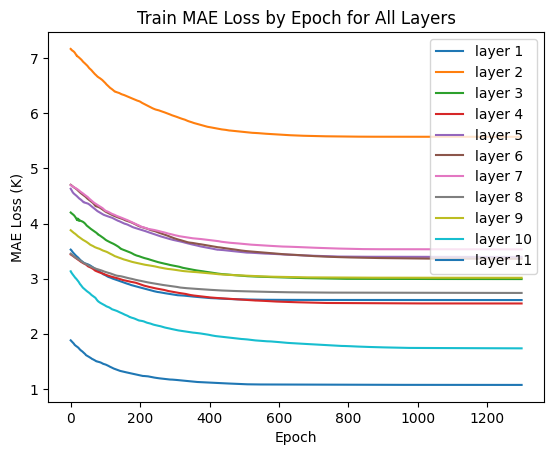

In [78]:
for layer in layers:
    plt.plot(layer['train losses'][200:], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [79]:
test_losses = []
test_criterion = args['test criterion']

for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

        layer['test pred'] = pred

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

print(f"Average: {sum(test_losses)/len(test_losses)}")

layer 1 loss: 4.558896541595459
layer 2 loss: 9.568453788757324
layer 3 loss: 4.697767734527588
layer 4 loss: 4.39523983001709
layer 5 loss: 5.6990647315979
layer 6 loss: 5.521470069885254
layer 7 loss: 5.365213871002197
layer 8 loss: 4.320059299468994
layer 9 loss: 4.621354103088379
layer 10 loss: 2.8420751094818115
layer 11 loss: 1.8472357988357544
Average: 4.8578937162052505


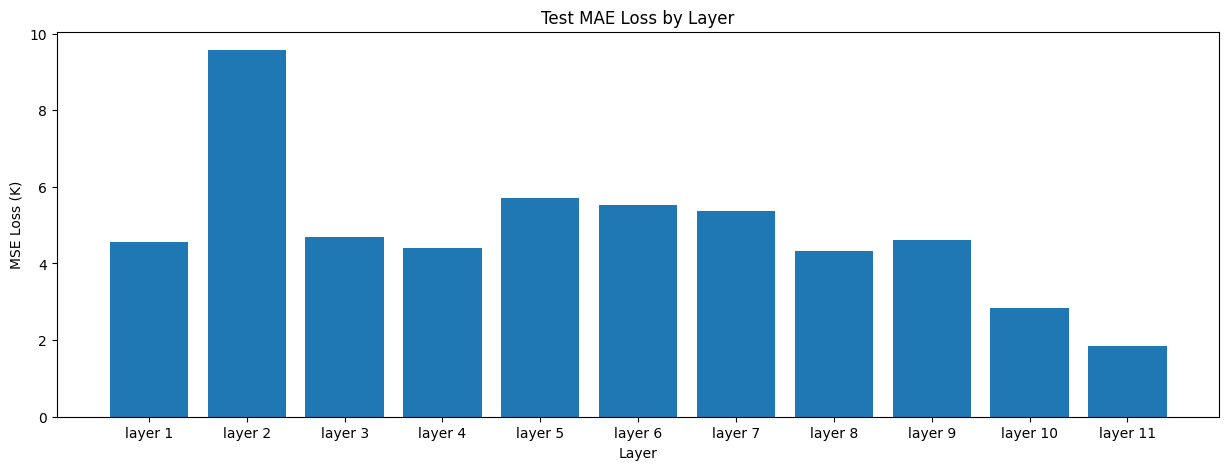

In [80]:
plt.figure(figsize=(15, 5))
plt.bar(y.columns, test_losses)

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [81]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [82]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

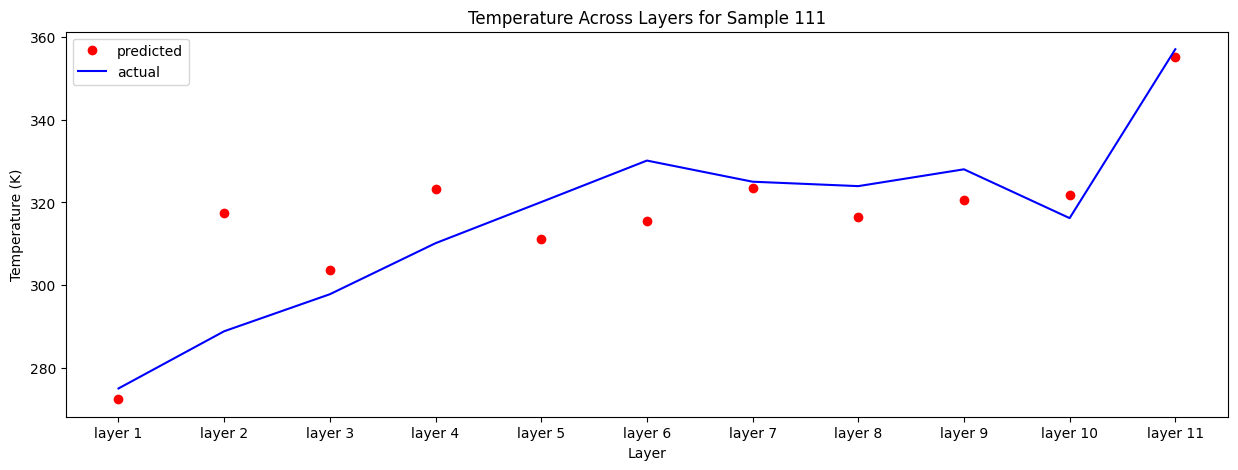

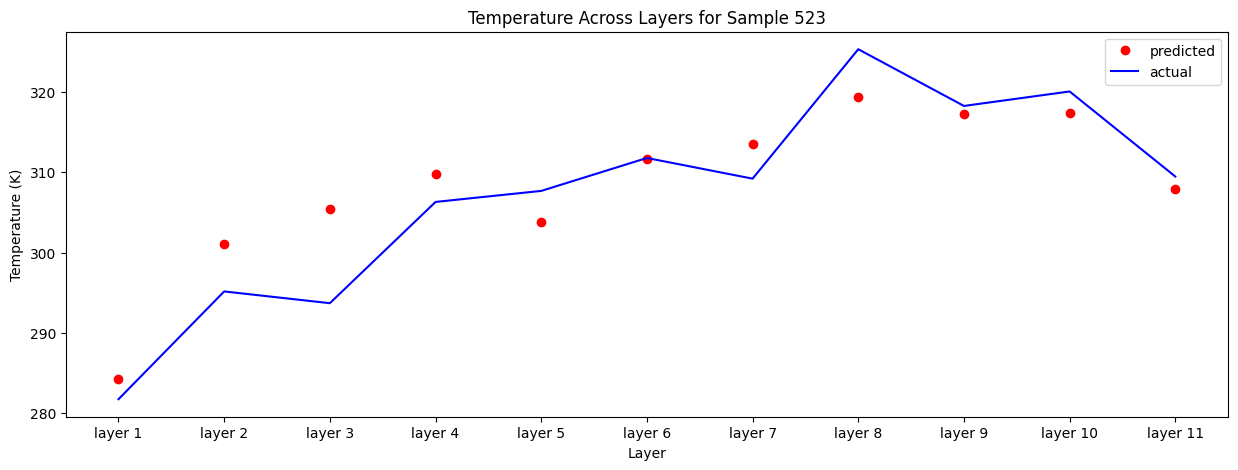

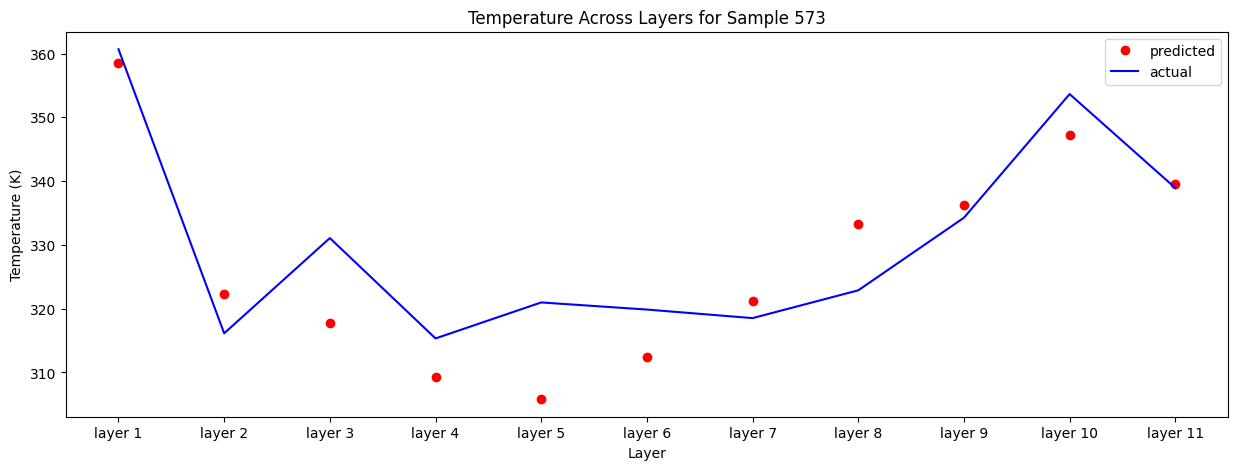

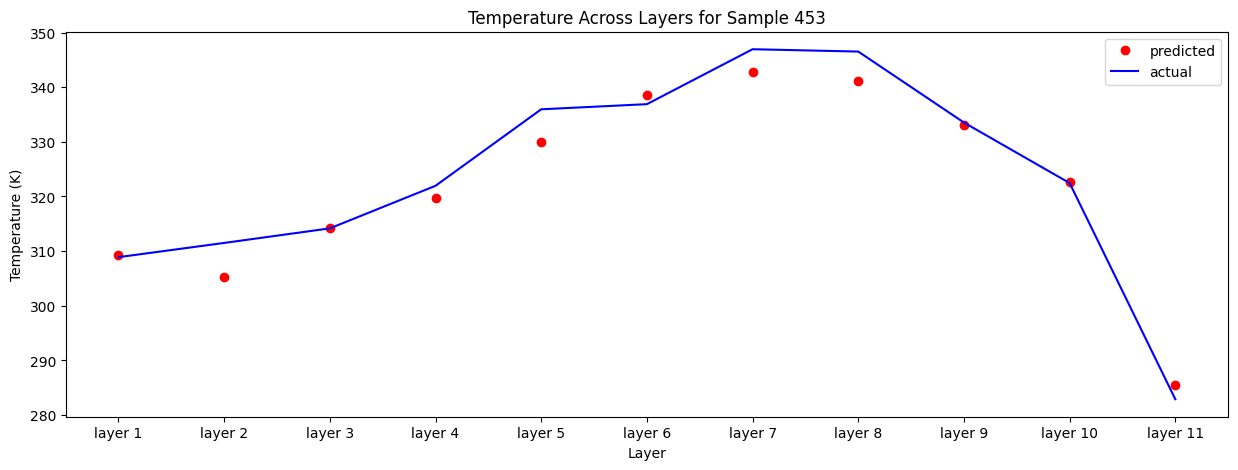

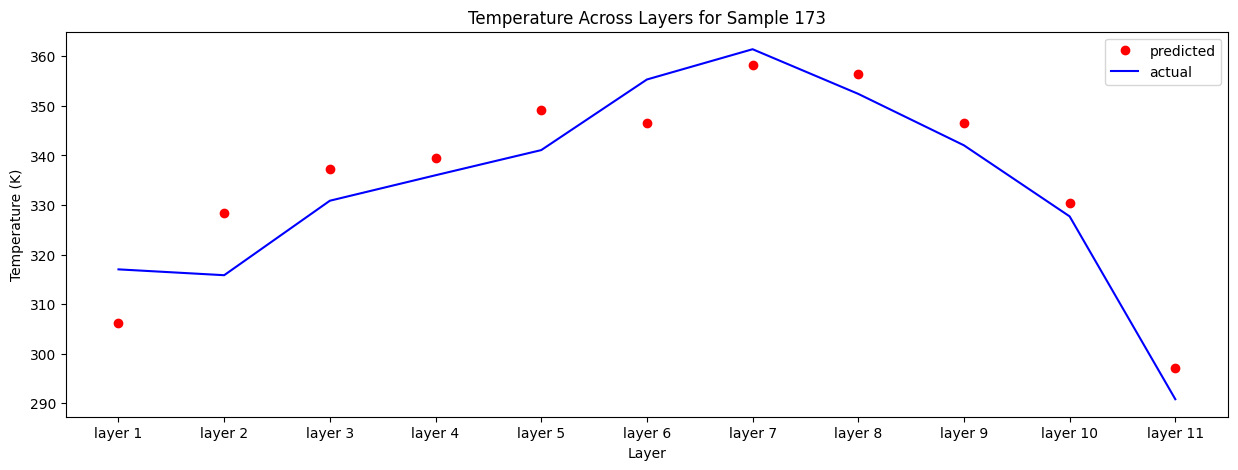

In [83]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)

In [84]:
with open('ff_one_layer_test.txt', "a") as f:
    f.write('===================================\n' +'|'.ljust(5) + f'{now.strftime("%m/%d/%Y, %H:%M:%S")}\n|\n')
    
    loss_str = ''
    for i in range(1, 12):
        loss_str += f'| layer {i} loss: '.ljust(20) + f'{test_losses[i-1]:.3f}\n'

    
    arg_str = ''
    for key in args:
        arg_str += f'| {key}:'.ljust(20) + f'{args[key]}\n'

    f.write('|'.ljust(10) + 'Losses\n' + f'|----------------------------------\n{loss_str}|\n'+ '|'.ljust(10) + 'Args' 
            + f'\n|----------------------------------\n{arg_str}====================================\n\n')